# Filtering Raw Patterns in HDF5

Process raw EBSD images in HDF5 file and save the Kikuchi signal.

In [22]:
import os
data_dir = "../../../xcdskd_example_data/GaN_Dislocations_1"
h5FileNameFull=os.path.abspath(data_dir+"/hdf5/GaN_Dislocations_1.hdf5")
#print(h5FileNameFull)
nbin=1   # binning factor for pattern processing

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import skimage.io 
import time
import sys
import h5py
from shutil import copyfile

from aloe.image import kikufilter

from aloe.plots import plot_image

In [25]:
# close HDF5 file if still open
if 'f' in locals():
    f.close()

# split off the extension
h5FileName, h5FileExt = os.path.splitext(h5FileNameFull)
h5FilePath, h5File =os.path.split(h5FileNameFull)


# copy to new file
src = h5FileName+h5FileExt
dst = h5FileName+'_processed'+h5FileExt
copyfile(src, dst)
# use new filename from here to work on
h5FileName = h5FileName+'_processed'


    
f=h5py.File(h5FileName+h5FileExt, "a") # append mode
#f=h5py.File(h5FileName+h5FileExt, "r")
#print('HDF5 full file name: '+h5FileNameFull)
#print('HDF5 File: '+h5FileName+h5FileExt)
#print('HDF5 Path: '+h5FilePath)

In [26]:
DataGroup="/Scan/EBSD/Data/"
HeaderGroup="/Scan/EBSD/Header/"
Patterns = f[DataGroup+"RawPatterns"]
XIndex =   f[DataGroup+"X BEAM"]
YIndex =   f[DataGroup+"Y BEAM"]
MapWidth = f[HeaderGroup+"NCOLS"].value
MapHeight= f[HeaderGroup+"NROWS"].value
PatternHeight=f[HeaderGroup+"PatternHeight"].value
PatternWidth =f[HeaderGroup+"PatternWidth"].value
print('Pattern Height: ', PatternHeight)
print('Pattern Width : ', PatternWidth)
PatternAspect=float(PatternWidth)/float(PatternHeight)
print('Pattern Aspect: '+str(PatternAspect))
print('Map Height: ', MapHeight)
print('Map Width : ', MapWidth)

Pattern Height:  256
Pattern Width :  336
Pattern Aspect: 1.3125
Map Height:  50
Map Width :  52


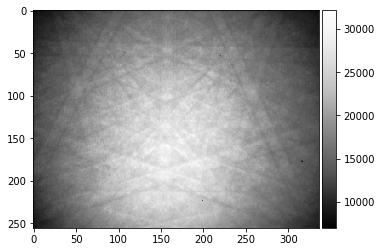

In [27]:
RawPattern=Patterns[1000,:,:]
plot_image(RawPattern)
#skimage.io.imsave('raw_pattern.tiff', RawPattern, plugin='tifffile')

In [28]:
# TRY OPTIONAL: make static background from average of all patterns in map
#StaticBackground=np.mean(Patterns[:], axis=0)
#f[HeaderGroup+"StaticBackground"] = StaticBackground

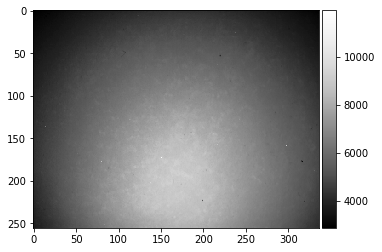

In [29]:
StaticBackground=f[DataGroup+"StaticBackground"]
plot_image(StaticBackground)
#np.savetxt('StaticBackground.txt',StaticBackground )

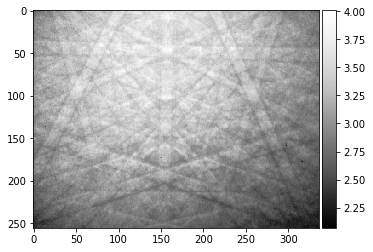

In [30]:
PatternFlat=RawPattern/StaticBackground
plot_image(PatternFlat)
#from scipy import misc
#misc.imsave('Pattern_Flatfielded.png',RawPattern)
#scipy.misc.toimage(image_array, cmin=0.0, cmax=...).save('outfile.jpg')

We test the parameters for the processing of the raw patterns in the HDF5 file:

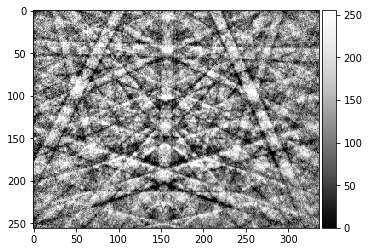

uint8


In [31]:
kpattern=kikufilter.process_ebsp(raw_pattern=RawPattern, 
                 static_background=StaticBackground, sigma=20,
                 clow=1.0, chigh=99.0, dtype=np.uint8, binning=nbin)
plot_image(kpattern)
print(kpattern.dtype)

We also check the static background:

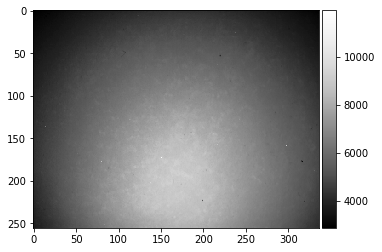

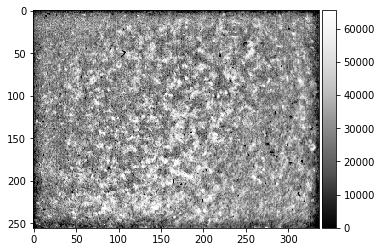

uint16


In [32]:
bgpattern=kikufilter.process_ebsp(raw_pattern=StaticBackground, 
                 static_background=None, sigma=15,
                 clow=0.5, chigh=99.5, dtype=np.uint16, binning=nbin)
plot_image(StaticBackground)
plot_image(bgpattern)
print(bgpattern.dtype)

## Save Processed Patterns in HDF5

In [33]:
nPatterns=MapWidth*MapHeight
print('Number of patterns: ',nPatterns)
    
# store *processed* patterns in HDF5    
# create empty data set, compress (max=9) using hdf5-gzip filter
dataset_name=DataGroup+'Patterns'
if not (dataset_name in f):
    print('create: ', dataset_name)
    dset_processed=f.create_dataset(dataset_name,
                           (nPatterns,PatternHeight//nbin,PatternWidth//nbin), 
                           dtype=np.uint8,
                           chunks=(1,PatternHeight//nbin,PatternWidth//nbin))
                           #compression='gzip',compression_opts=9)    
else:    
    # overwrite existing data
    print('data set already existing: overwriting ', dataset_name)
    dset_processed=f[dataset_name]
                                
#nPatterns=5    
# this is very slow...
for p in range(nPatterns):
    img_raw = np.copy(Patterns[p])
    img = kikufilter.process_ebsp(raw_pattern=img_raw, 
             static_background=StaticBackground, sigma=15,
             clow=1, chigh=99, dtype=np.uint8, binning=nbin)

    # update HDF5 data set
    dset_processed[p]=img

    # live update progress info
    if ( p % 10 == 0 ):
        progress=100.0*(p+1)/nPatterns
        sys.stdout.write("\rtotal patterns: %5i current:%5i progress: %4.2f%%"
                         % (nPatterns, p, progress) )
        sys.stdout.flush()
        
f.close() 

Number of patterns:  2600
create:  /Scan/EBSD/Data/Patterns
total patterns:  2600 current: 2590 progress: 99.65%

In [34]:
f.close()            

### Test: Plotting the processed patterns

In [35]:
f=h5py.File(h5FileName+h5FileExt, "r")

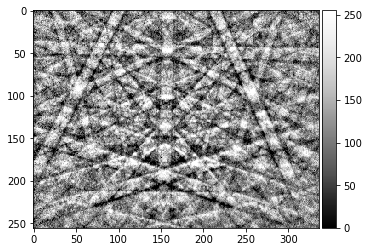

In [36]:
kPatterns = f[DataGroup+"Patterns"]
plot_image(kPatterns[2500])

In [37]:
indexmap = f[HeaderGroup+"indexmap"]


def get_npa(x, y, patterns, indexmap, nn=0):
    """ get neighbor pattern average
    
    use -nn..+nn neighbors, 
    i.e. at nn=1, there will be 8 neighbors = 9 pattern average
    
    patterns in assumed to be 1D array of 2D patterns
    index of pattern as function of x,y is in indexmap
    """
    ref_pattern = np.copy(patterns[indexmap[x,y]]).astype(np.int64)
    npa = np.zeros_like(ref_pattern, dtype=np.int64)
    for ix in range(x-nn,x+nn+1):
        for iy in range(y-nn, y+nn+1):
            print(ix, iy)
            if ((ix<0) or (ix>=patterns.shape[1]) or (iy<0) or (iy>=patterns.shape[0])):
                npa = npa + ref_pattern
            else:
                npa = npa + patterns[indexmap[ix,iy]]
    return npa      

23 23
23 24
23 25
24 23
24 24
24 25
25 23
25 24
25 25


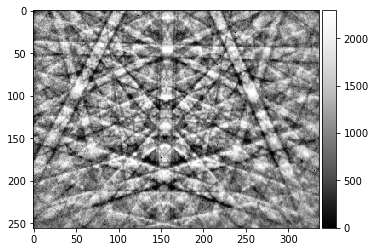

In [38]:
img_npa = get_npa(24, 24, kPatterns, indexmap, nn=1)
plot_image(img_npa)